In [ ]:
!pip install torchinfo

import torch
import numpy as np
import pandas as pd
from torch.utils import data
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Check Device configuration
tensor_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

dataset.isna().sum()

dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print("shape of train_dataset: ", train_dataset.shape)
print("shape of test_dataset: ", test_dataset.shape)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')
print("shape of train_features: ", train_features.shape)
print("shape of test_features: ", test_features.shape)
print("shape of train_labels: ", train_labels.shape)
print("shape of test_labels: ", test_labels.shape)

batch = 10
X =np.array(train_features.values.astype(np.float32))
X = torch.Tensor(X)
print(X.shape)
y = np.array(train_labels.values.astype(np.float32))
y = torch.Tensor(y)
print("before reshape: ", y.shape)
y = torch.reshape(y, (-1,1))
print("after reshape: ", y.shape)

train = TensorDataset(X,y)
train_dataloader = DataLoader(train, batch_size=batch, shuffle=True)
sample = next(iter(train_dataloader))
print("sample batch: ", sample)
print("batch len: ", len(sample))

for X, y in train_dataloader:
    print(f"Shape of X [B, F]: {X.shape}")
    print(f"Shape of y [B, L]: {y.shape} {y.dtype}")
    break

X = np.array(test_features.values.astype(np.float32))
X = torch.Tensor(X)
y = np.array(test_labels.values.astype(np.float32))
y = torch.Tensor(y)
y = torch.reshape(y, (-1,1))
test = TensorDataset(X,y)
test_dataloader = DataLoader(test, batch_size=batch, shuffle=True)
sample = next(iter(test_dataloader))
print("sample batch: ", sample[0])
print("batch len: ", len(sample))

for X, y in test_dataloader:
    print(f"Shape of X [B, F]: {X.shape}")
    print(f"Shape of y [B, L]: {y.shape} {y.dtype}")
    break

class NNModel(nn.Module):
    def __init__(self):
        # super(NNModel, self).__init__()
        super().__init__()
        self.norm = nn.BatchNorm1d(9)
        self.fc1 = nn.Linear(9,1)
    def forward(self, x):
        out = self.norm(x)
        out = self.fc1(out)
        return out
class NNModel2(nn.Module):
    def __init__(self):
        # super(NNModel, self).__init__()
        super().__init__()
        self.norm = nn.BatchNorm1d(9)
        self.fc1 = nn.Linear(9,10)
        self.fc2 = nn.Linear(10,20)
        self.fc3 = nn.Linear(20,10)
        self.fc4 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.norm(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out
class NNModel3(nn.Module):
    def __init__(self):
        # super(NNModel, self).__init__()
        super().__init__()
        self.norm = nn.BatchNorm1d(9)
        self.fc1 = nn.Linear(9, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 30)
        self.fc4 = nn.Linear(30, 20)
        self.fc5 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.norm(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.fc5(out)
        return out


nnet1 = NNModel()
nnet2 = NNModel2()
nnet3 = NNModel3()
nnets = [nnet1, nnet2, nnet3]

batch = 10

for nnet in nnets:
    # Initiate TensorBoard writer
    writer = SummaryWriter()

    summary(nnet, input_size=(batch, 9), device='cpu', col_names=['input_size', 'output_size',
                                                                  'num_params'])
    def train(dataloader, model, loss_fn, optimizer, device, epoch):
        size = len(dataloader.dataset)
        print("size: ", size)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            #print("X: " , X)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            if batch % 10 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                writer.add_scalar("Loss/train", loss, epoch * len(dataloader) + batch)

    def test(dataloader, model, loss_fn, device):
        size = len(dataloader.dataset)
        print("size: ", size)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(nnet.parameters(), lr=0.01)

    device = 'cuda'
    device = tensor_device
    nnet = nnet.to(device=device)
    epochs = 20
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train(train_dataloader, nnet, criterion, optimizer, device, epoch)
        test(test_dataloader, nnet, criterion, device)
    print("Done!")

    sample = next(iter(test_dataloader))
    Y = nnet(sample[0].to(device=device))
    print("Real labels: ", sample[1])
    print("Predicted labels: ", Y)

    # TensorBoard stuff
    writer.flush()
    writer.close()


The model with the least ammount of error for validation was the five-layer network, followed very closely in second by the four-layer network, and a very distant third in the simple-layer network. Shown below is a tensor graph.
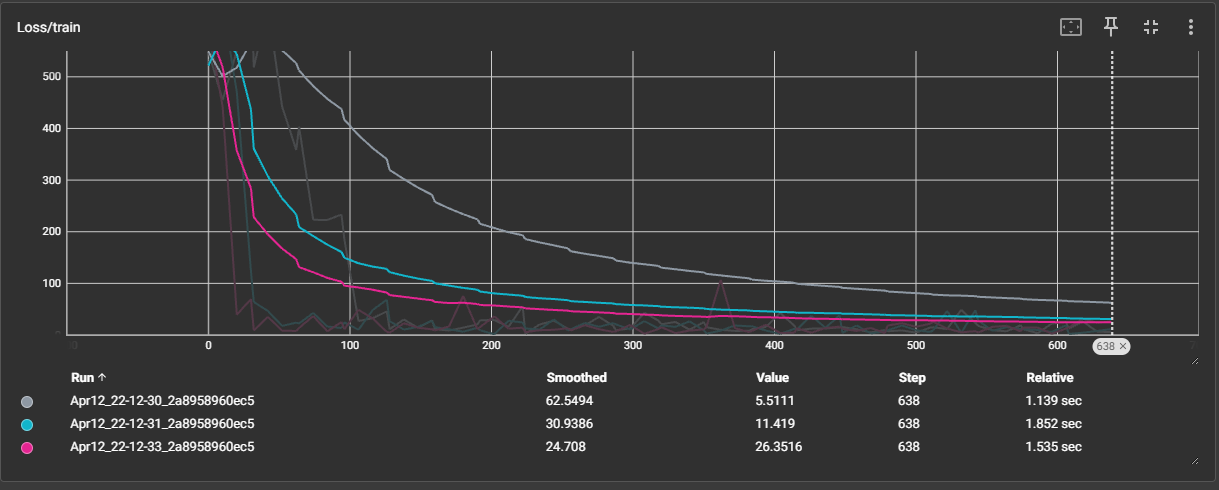